In [2]:
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import dask.array as da
import dask.dataframe as dd
import xarray as xr
from xnemogcm import open_domain_cfg, get_metrics
import xgcm
import cartopy.crs as ccrs
import cmocean
import numpy as np
from scipy.stats import linregress
import datetime
import pandas as pd
# Add SouthernDemons library to PATH
sys.path.append(os.path.abspath("../lib/"))
from teos_ten import teos_sigma0
import datesandtime

In [2]:
# Subdomain information (As inputted into TRACMASS, note non-pythonic indexing)
imindom = 1
imaxdom = 1440
jmindom = 1
jmaxdom = 400
kmindom = 1
kmaxdom = 75

# Location of the TRACMASS run
data_dir = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/ORCA025_fwd/")

# Location of the OUTPUT directory created when running SouthernDemons executable
out_dir = os.path.abspath(data_dir + "/OUTPUT.ORCA025_fwd/")

# Location of masks and grid information for the model

# mask_path = os.path.abspath("/gws/nopw/j04/aopp/astyles/TRACMASS_DATA/DRAKKAR_SET/ORCA025/topo/mask.nc")
# hgrid_path = os.path.abspath("/gws/nopw/j04/aopp/astyles/TRACMASS_DATA/DRAKKAR_SET/ORCA025/topo/mesh_hgr.nc")
# zgrid_path = os.path.abspath("/gws/nopw/j04/aopp/astyles/TRACMASS_DATA/DRAKKAR_SET/ORCA025/topo/mesh_zgr.nc")

cal_months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

In [3]:
df_ini = dd.read_parquet(out_dir + f"/df_ini.combined.parquet")
df_out = dd.read_parquet(out_dir + f"/df_out.combined.parquet")
df_vent = dd.read_parquet(out_dir + f"/df_vent.parquet")

In [22]:
df = df_vent[['year_o','subvol_o']]
df_group = df.groupby(['year_o'])
vol_out = df_group.sum()["subvol_o"].compute()
vol_out = vol_out.reset_index()

In [5]:
type(vol['subvol_o'])

pandas.core.series.Series

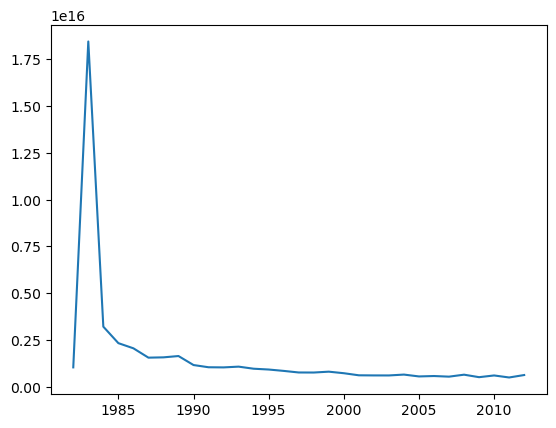

In [72]:
plt.plot(vol['year_o'],vol['subvol_o'])

In [ ]:
####need to normalise by number of trajectories still remaining?
#volume = tot_init -  df_out

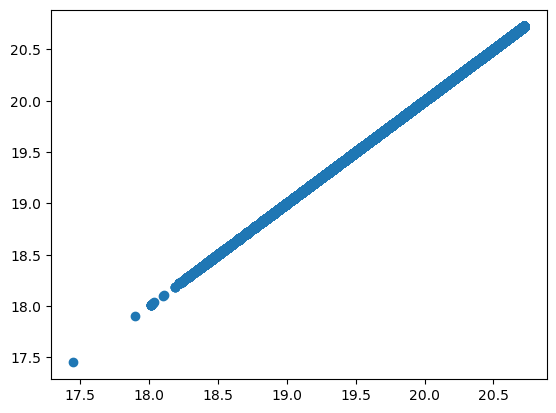

In [80]:
#check volume conservation:
df = df_vent[['subvol_i','subvol_o']]
plt.scatter(np.log(df['subvol_i'].compute()),np.log(df['subvol_o'].compute()))

(0.0, 0.0001)

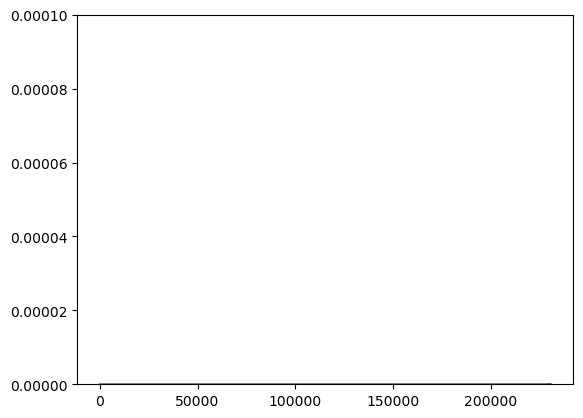

In [83]:
plt.plot(df['subvol_i'].compute()-df['subvol_o'].compute())
plt.ylim(0,0.0001)                

In [79]:
linregress(df['subvol_i'].compute(),df['subvol_o'].compute())

LinregressResult(slope=np.float64(1.0), intercept=np.float64(0.0), rvalue=np.float64(1.0), pvalue=np.float64(0.0), stderr=np.float64(0.0), intercept_stderr=np.float64(0.0))

In [5]:
#time init
df_vent[['year_i','month_i','day_i','time_i']].tail(1)

,year_i,month_i,day_i,time_i
229592,1982,12,16,0.0


In [46]:
#volume that leaves the system
vol_tot = df_ini.sum()["subvol"].compute()
df = df_out[['time','subvol']]
df['year'] = datesandtime.sec_to_datetime_365day(df['time'],year0=1982, month0=12, day0=16)
df_group = df.groupby(['year'])
vol_rem = df_group.sum()["subvol"].compute()
vol_rem = vol_rem.reset_index()
vol_rem['remaining'] = vol_tot - vol_rem['subvol'].cumsum()

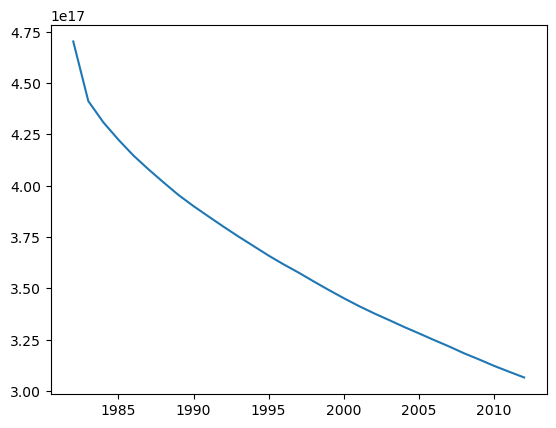

In [21]:
plt.plot(vol.year,vol.remaining)

Text(0, 0.5, 'normalised ventilation volume')

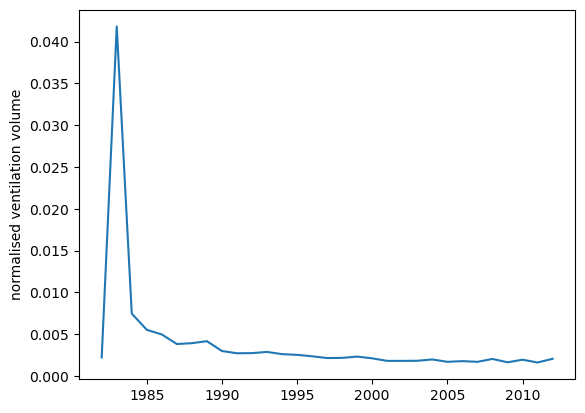

In [38]:
plt.plot(vol_out['year_o'],vol_out['subvol_o']/vol.remaining)
plt.ylabel('normalised ventilation volume')

In [1]:
###increase resolution do month and year

In [19]:
df = df_vent[['year_o','month_o','subvol_o']]
#df['year'] = datesandtime.sec_to_datetime_365day(df['time'],year0=1982, month0=12, day0=16)
df_group = df.groupby(['year_o','month_o'])
vol = df_group.sum()["subvol_o"].compute()

vol = vol.reset_index()
vol['date'] = pd.to_datetime( dict(year=vol.year_o, month=vol.month_o, day=1))
vol = vol.sort_values('date')
vol = vol.reset_index()
#vol['remaining'] = vol_tot - vol['subvol'].cumsum()

In [68]:
vol = vol.merge(
    vol_rem[['year', 'remaining']],
    left_on='year_o',
    right_on='year',
    how='left'
)

# Drop the redundant 'year' column from vol if it's not needed
vol = vol.drop(columns=['year'])

In [66]:
vol

,index,year_o,month_o,subvol_o,date
0,0,1982,12,1.036173e+15,1982-12-01
1,1,1983,1,7.473684e+14,1983-01-01
2,173,1983,2,7.560677e+14,1983-02-01
3,174,1983,3,1.843531e+15,1983-03-01
4,2,1983,4,1.980335e+15,1983-04-01
...,...,...,...,...,...
356,169,2012,8,1.205278e+14,2012-08-01
357,170,2012,9,7.841011e+13,2012-09-01
358,171,2012,10,3.403636e+13,2012-10-01
359,172,2012,11,2.588697e+12,2012-11-01


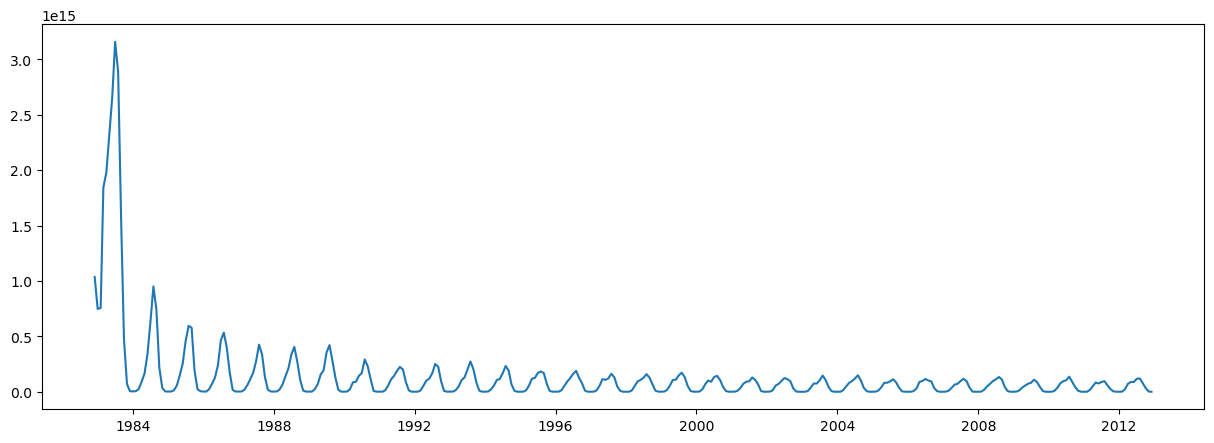

In [20]:
fig = plt.figure(figsize=(15,5))
plt.plot(vol['date'],vol.subvol_o)


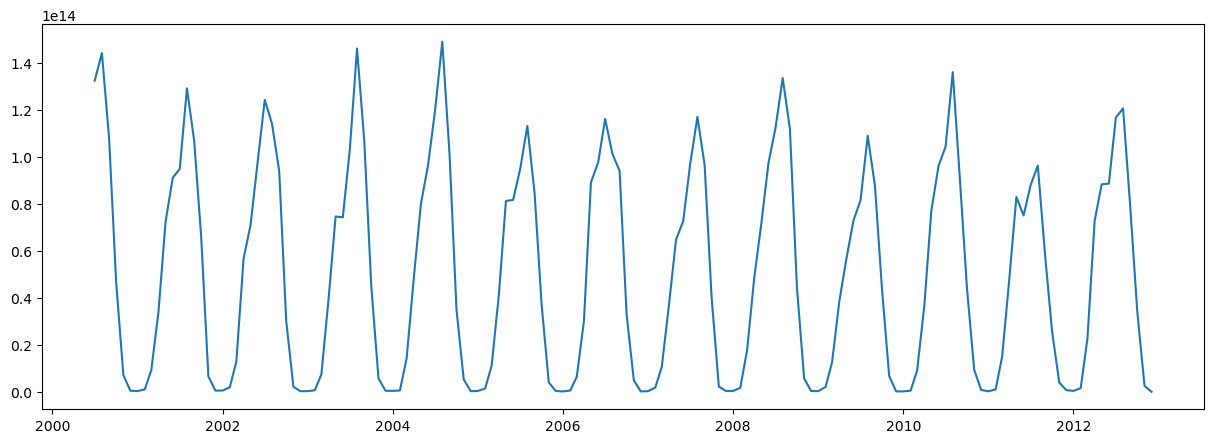

In [21]:
fig = plt.figure(figsize=(15,5))
plt.plot(vol['date'].iloc[-150:],vol.subvol_o.iloc[-150:])

In [62]:
vol.iloc[160:180]

,year_o,month_o,subvol_o,date,remaining
160,2010,11,9.387268e+12,2010-11-01,3.121481e+17
161,2011,2,1.084368e+12,2011-02-01,3.092933e+17
162,2011,3,1.511741e+13,2011-03-01,3.092933e+17
163,2011,7,8.789445e+13,2011-07-01,3.092933e+17
164,2011,12,7.886337e+11,2011-12-01,3.092933e+17
165,2012,1,4.709183e+11,2012-01-01,3.064994e+17
166,2012,4,7.282485e+13,2012-04-01,3.064994e+17
167,2012,5,8.827269e+13,2012-05-01,3.064994e+17
168,2012,6,8.859277e+13,2012-06-01,3.064994e+17
169,2012,8,1.205278e+14,2012-08-01,3.064994e+17


In [ ]:
#check the depth of seeding vs time to ventilate

[]

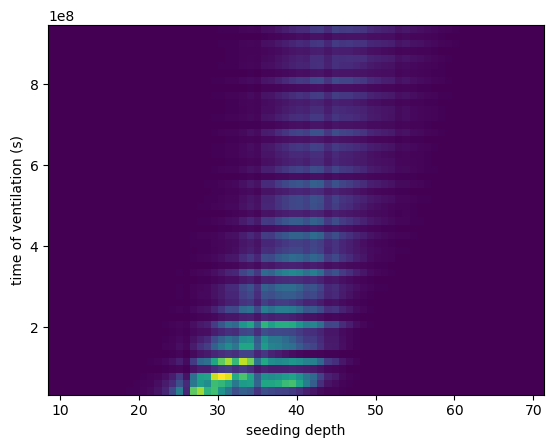

In [7]:
df = df_vent[df_vent['year_o']>1983]
plt.hist2d(df.z_i.compute(),df.time_o.compute(),bins = (70,50))
plt.xlabel('seeding depth')
plt.ylabel('time of ventilation (s)')
plt.plot()

In [ ]:
### try to rectreate seasonality of mixed layer depth:
#look at depth at termination (grouped by x,y)
#then plot each year and show seasonality 9 use time in doy!!!





In [9]:
df_finalz = df_vent[['z_o', 'year_o', 'month_o']]
df_group_z = df_finalz.groupby(['month_o','year_o'])
mean_z = df_group_z.mean()['z_o'].compute()
mean_z = mean_z.reset_index()
mean_z['date'] = pd.to_datetime( dict(year=mean_z.year_o, month=mean_z.month_o, day=1))
mean_z =mean_z.sort_values('date')
mean_z = mean_z.reset_index()


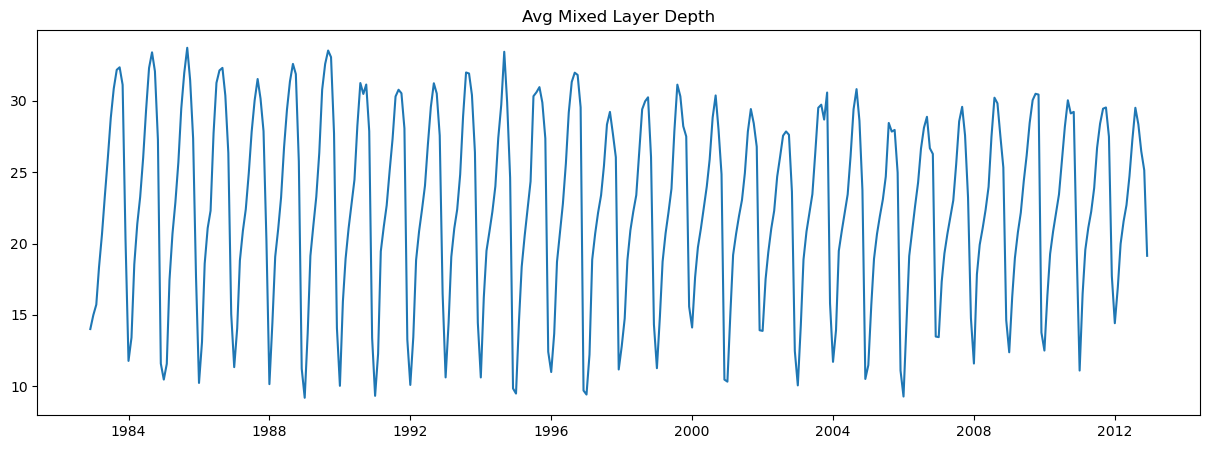

In [36]:
fig = plt.figure(figsize=(15,5))
plt.plot(mean_z.date,mean_z.z_o)
plt.title('Avg Mixed Layer Depth')
plt.show()

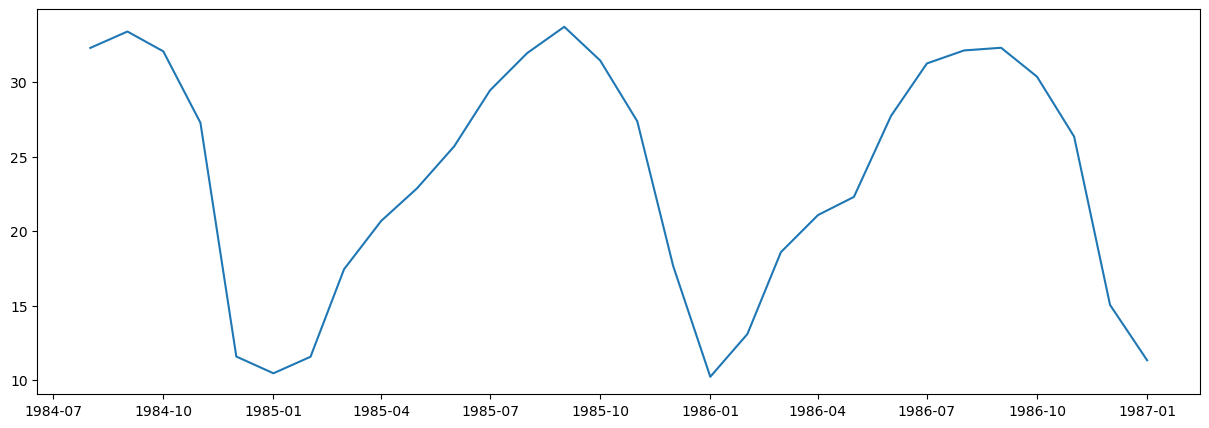

In [38]:
fig = plt.figure(figsize=(15,5))
plt.plot(mean_z.date.iloc[20:50],mean_z.z_o.iloc[20:50])

Text(0.5, 1.0, 'Comparisson of timing of ventilation and ML movemnet')

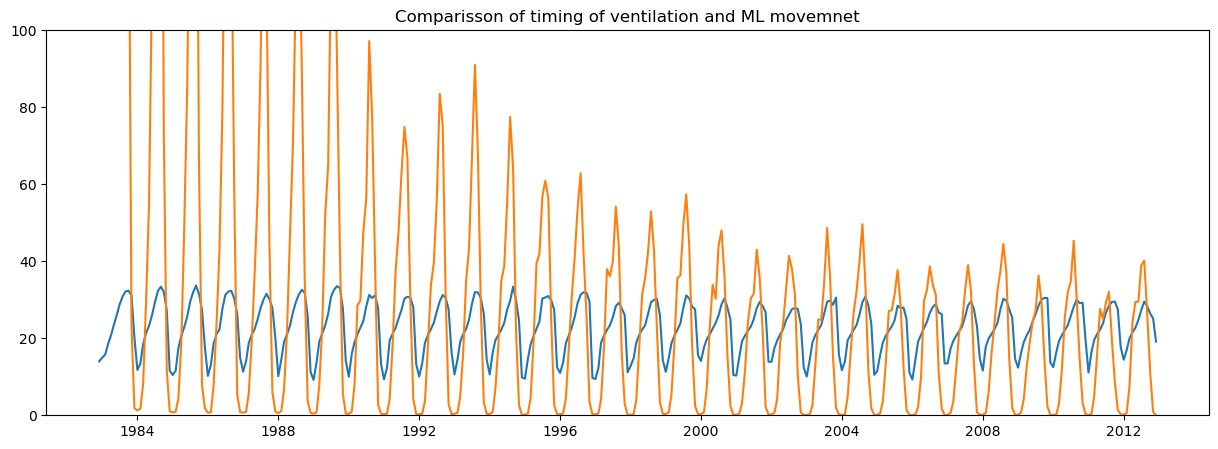

In [37]:
fig = plt.figure(figsize = (15,5))
plt.plot(mean_z.date,mean_z.z_o)
plt.plot(vol['date'],vol.subvol_o/0.3e13)
plt.ylim(0,100)
plt.title('Comparisson of timing of ventilation and ML movemnet')

In [8]:
df_vent.head(2)

,ntraj_o,x_o,y_o,z_o,subvol_o,time_o,boxface_o,temp_o,sal_o,density_o,...,year_o,month_o,day_o,dayofyear_o,binnedx_i,binnedy_i,binnedz_i,binnedx_o,binnedy_o,binnedz_o
0,4224,1200.18,334.99,17.85,7.620966e+08,302400.0,0,15.93,35.43,25.96,...,1982,12,19,353,1200,335,17,1200,335,18
1,635086,1198.02,319.50,14.50,6.773663e+08,4320.0,0,11.43,34.64,26.29,...,1982,12,16,350,1198,319,14,1198,319,14


In [ ]:
# density at ventilation

In [ ]:
#teos_sigma0(T,S)

In [21]:
#df_vent['density'] = teos_sigma0(df_vent['temp_o'],df_vent['sal_o'])
df = df_vent[['density_o','month_o','year_o']]
df_group_z = df.groupby(['month_o','year_o'])
mean_z = df_group_z.mean()['density_o'].compute()
mean_z = mean_z.reset_index()
mean_z['date'] = pd.to_datetime( dict(year=mean_z.year_o, month=mean_z.month_o, day=1))
mean_z =mean_z.sort_values('date')
mean_z = mean_z.reset_index()




Text(0, 0.5, 'avg density')

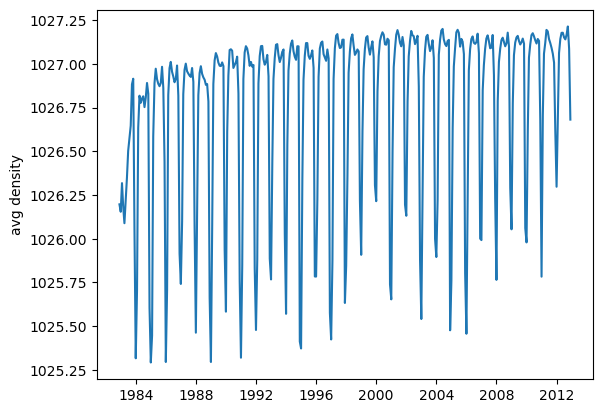

In [15]:
plt.plot(mean_z['date'],mean_z['density_o'])
plt.ylabel('avg density')

0    1025.966369
Name: density, dtype: float64


0    25.96
Name: density_o, dtype: float64